**Projet 8: Traiter les images pour le système embarqué d’une voiture autonome** 

Dans ce notebook, nous allons tester différents modèles pour réaliser une segmentation en 8 catégories des images pour le système embarqué d'une voiture autonome;
Nous commencerons par des modèles "basiques", qui seront notre baseline de référence vs des modeles plus élaborés de deep learning.
Dans l'orde nous allons tester:
* 

Tous les modeles sont stockés en centralisé sur MLflow (local).
Le modèle le plus performant (avec la meilleure accuracy) sera utilisé pour le déploiement en production sur le cloud via un API de prediction.
Derriere, nous developperons également un pipeline CI/CD qui nous aidera à déployer le dernier modele automatiquement sur le cloud sur simple PUSH via Git Hub Actions;

> "View" > "Table of contents" pour voir le plan du notebook

# 1. Imports et paramétrages

## 1.1 Installation des librairies

In [1]:
!pip install pandas numpy matplotlib scikit-learn missingno mlflow tf-keras tqdm albumentations tf-keras==2.16.0

In [2]:
# !pip install pandas numpy seaborn matplotlib scikit-learn missingno nltk 
# !pip install gensim transformers tensorflow-cpu==2.16.1 tf-keras==2.16.0 tensorflow_hub plot-keras-history
# !pip install opencv-python-headless opencv-contrib-python 

## 1.2 Import des Librairies

In [2]:
# 1. Manipulation de données et calculs numériques :
import numpy as np
import pandas as pd
import math
import multiprocessing

# 2. Gestion de fichiers et chemins :
import os
from pathlib import Path

# 3. Visualisation :
import matplotlib.pyplot as plt
import tqdm

# 4. Traitement d'images et augmentations :
import cv2
from tensorflow.keras.preprocessing import image
import albumentations as A

# 5. TensorFlow et Keras (modèles, couches, optimisations, pertes, callbacks) :
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, losses, callbacks, backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.saving import register_keras_serializable

# 6. MLflow (suivi d'expériences et centralisation des modèles) :
import mlflow

In [4]:
! pip freeze

absl-py==2.1.0
albucore==0.0.23
albumentations==2.0.5
alembic==1.14.1
annotated-types==0.7.0
anyio==4.8.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
astunparse==1.6.3
async-lru==2.0.4
attrs==25.1.0
babel==2.17.0
beautifulsoup4==4.13.3
bleach==6.2.0
blinker==1.9.0
cachetools==5.5.2
certifi==2025.1.31
cffi==1.17.1
charset-normalizer==3.4.1
click==8.1.8
cloudpickle==3.1.1
colorama==0.4.6
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
databricks-sdk==0.44.1
debugpy==1.8.12
decorator==5.2.1
defusedxml==0.7.1
Deprecated==1.2.18
docker==7.1.0
executing==2.2.0
fastjsonschema==2.21.1
Flask==3.1.0
flatbuffers==25.2.10
fonttools==4.56.0
fqdn==1.5.1
gast==0.6.0
gitdb==4.0.12
GitPython==3.1.44
google-auth==2.38.0
google-pasta==0.2.0
graphene==3.4.3
graphql-core==3.2.6
graphql-relay==3.2.0
greenlet==3.1.1
grpcio==1.70.0
h11==0.14.0
h5py==3.13.0
httpcore==1.0.7
httpx==0.28.1
idna==3.10
importlib_metadata==8.5.0
ipykernel==6.29.5
ipython==9.0.0
ipython_pygments_lexers=

## 1.3 Paramétrages

In [5]:
#parametrage de panda pour afficher toutes les colonnes sans les tronquer
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [3]:
# Configuration MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("segmentation_images")

<Experiment: artifact_location='mlflow-artifacts:/615947391303416845', creation_time=1741172112987, experiment_id='615947391303416845', last_update_time=1741172112987, lifecycle_stage='active', name='segmentation_images', tags={}>

## 1.4 Fonctions

### 1.4.1 Obtention des chemins pour images et masques

In [4]:
# Extensions valides pour les images
IMAGE_MASK_EXTENSIONS = {".png", ".jpg", ".jpeg", ".npy"}

In [5]:

def get_image_paths(root_dir):
    """
    Récupère les chemins des images en parcourant récursivement les dossiers.
    Trie les chemins en fonction de leur emplacement relatif pour assurer l'alignement entre images et masques.
    Ignore les images du dossier 'test/' car leurs masques relatifs ne sont pas fournis par Cityscape.
    """
    paths = [
        p for p in Path(root_dir).rglob("*") 
        if p.suffix.lower() in IMAGE_MASK_EXTENSIONS
        and ("train" in str(p) or "val" in str(p))  # Ignore "test/"
    ]
    return sorted(paths, key=lambda p: p.relative_to(root_dir))


In [6]:
def get_mask_paths(root_dir, mask_type="_gtFine_labelIds"):
    """
    Récupère les chemins des masques en filtrant ceux contenant un type spécifique.
    Utilise les masques de segmentation sémantique (_gtFine_labelIds).
    Ignore les masques du dossier 'test/' car ils ne sont pas fournis.
    """
    paths = [
        p for p in Path(root_dir).rglob("*")
        if p.suffix.lower() in IMAGE_MASK_EXTENSIONS 
        and mask_type in p.stem 
        and ("train" in str(p) or "val" in str(p))  # Ignore "test/"
    ]
    return sorted(paths, key=lambda p: p.relative_to(root_dir))


### 1.4.2 Simplification des catégories

code pour visualiser les différentes categs de cityscapes. 
Ce code provient directement du github de cityscapes: 
https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

In [7]:
from collections import namedtuple

In [8]:
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


#--------------------------------------------------------------------------------
# Main for testing
#--------------------------------------------------------------------------------

# just a dummy main
if __name__ == "__main__":
    # Print all the labels
    print("List of cityscapes labels:")
    print("")
    print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( 'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color' ))
    print("    " + ('-' * 98))
    for label in labels:
        print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( label.name, label.id, label.trainId, label.category, label.categoryId, label.hasInstances, label.ignoreInEval, label.color ))
    print("")

List of cityscapes labels:

                     name |  id | trainId |       category | categoryId | hasInstances | ignoreInEval
    --------------------------------------------------------------------------------------------------
                unlabeled |   0 |     255 |           void |          0 |            0 |            1
              ego vehicle |   1 |     255 |           void |          0 |            0 |            1
     rectification border |   2 |     255 |           void |          0 |            0 |            1
               out of roi |   3 |     255 |           void |          0 |            0 |            1
                   static |   4 |     255 |           void |          0 |            0 |            1
                  dynamic |   5 |     255 |           void |          0 |            0 |            1
                   ground |   6 |     255 |           void |          0 |            0 |            1
                     road |   7 |       0 |          

In [9]:
# Catégories simplifiées
categs = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

In [10]:
# Mapping des indices aux catégories
category_mapping = {
    0: 'void',
    1: 'flat',
    2: 'constrc.',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle'
}

In [11]:
def make_mask(img):
    """
    Simplifie les labels du masque en transformant les 32 sous-catégories en 8 catégories principales.
    Retourne un masque de dimensions (H, W) où chaque pixel contient l'ID de la catégorie.
    """
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)  # Masque 2D
    for i, cat in enumerate(categs.values()):  # Parcourt les catégories
        mask[np.isin(img, cat)] = i  # Assigne l'ID de la catégorie
    return mask.astype(np.uint8)  # Assurer uint8

### 1.4.3 Colorisation du mask

In [12]:
# Dictionnaire de couleurs avec des clés en entiers
color_map = {
    0: [50, 50, 50],     # void (gris foncé neutre)
    1: [210, 180, 140],  # flat (ton sable/taupe)
    2: [220, 120, 60],   # construction (brique/orange)
    3: [255, 215, 0],    # object (jaune doré)
    4: [60, 180, 75],    # nature (vert dynamique)
    5: [135, 206, 235],  # sky (bleu ciel clair)
    6: [255, 0, 0],      # human (rouge vif)
    7: [0, 0, 255]       # vehicle (bleu vif)
}


In [13]:
# # Dictionnaire de couleurs avec des clés en entiers
# color_map = {
#     0: [50, 50, 50],       # void
#     1: [128, 64,128],   # flat
#     2: [102,102,156], # construction
#     3: [153,153,153],   # object
#     4: [0, 255, 0],     # nature
#     5: [0, 204, 204],   # sky
#     6: [255, 0, 0],     # human
#     7: [0, 0, 255]      # vehicle
# }

In [14]:
# # Dictionnaire de couleurs avec des clés en entiers
# color_map = {
#     0: [0, 0, 0],       # void
#     1: [153, 153, 0],   # flat
#     2: [255, 204, 204], # construction
#     3: [255, 0, 127],   # object
#     4: [0, 255, 0],     # nature
#     5: [0, 204, 204],   # sky
#     6: [255, 0, 0],     # human
#     7: [0, 0, 255]      # vehicle
# }

In [15]:
def apply_color_map(mask):
    """
    Applique une colormap personnalisée à un masque en niveaux de gris.
    """
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for label, color in color_map.items():
        color_mask[mask == label] = color  # Remplace chaque pixel par sa couleur

    return color_mask

def apply_color_map(mask):
    """
    Applique une colormap personnalisée à un masque en one-hot encoding ou en indices. Pour la visualisation de la segmentation
    """
    # Si le masque est en one-hot encoding, on le convertit en indices
    if mask.ndim == 3 and mask.shape[-1] > 1:
        mask = np.argmax(mask, axis=-1) # Transformation en single-channel pour affichage (on garde la classe la plus présente par pixel)

    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for label, color in color_map.items():
        color_mask[mask == label] = color  # Remplace chaque pixel par sa couleur

    return color_mask

### 1.4.4 Process & save masks

In [16]:
def process_and_save_masks(base_dir, mask_dir, save_dir, mask_type, mask_size):
    """
    Traite et sauvegarde les masques de segmentation sous format .npy en conservant 
    la structure des dossiers d'origine (train/val). 

    Args:
        base_dir (Path or str): Répertoire de base où enregistrer les masques convertis.
        mask_dir (Path or str): Répertoire contenant les masques originaux.
        mask_type (str, optional): Type de masque à filtrer. Default: "_gtFine_labelIds".
        mask_size (tuple, optional): Taille cible des masques. Default: (256, 256).
    """

    save_dir.mkdir(parents=True, exist_ok=True)  # Création du dossier si inexistant

    # Récupération des chemins des masques filtrés
    mask_paths = get_mask_paths(mask_dir, mask_type=mask_type)

    # Traitement des masques
    for file_path in tqdm.tqdm(mask_paths, desc="Processing masks"):
        try:
            # Déterminer le sous-dossier (train ou val)
            relative_path = file_path.relative_to(mask_dir)
            subdir = relative_path.parent  # Ex: train ou val

            # Construire le chemin de sauvegarde
            save_subdir = save_dir / subdir
            save_subdir.mkdir(parents=True, exist_ok=True)

            save_path = save_subdir / (file_path.stem + ".npy")

            # Vérifier si le fichier existe déjà
            if save_path.exists():
                continue  # Évite de traiter un fichier déjà sauvegardé

            # Vérification du format d'image
            if file_path.suffix.lower() not in IMAGE_MASK_EXTENSIONS:
                print(r" /!\  Fichier ignoré (mauvais format) : {file_path}")
                continue

            # Chargement et conversion du masque
            mask = image.load_img(file_path, color_mode="grayscale", target_size=mask_size)
            mask = np.array(mask, dtype=np.uint8)  # Convertir en tableau NumPy

            # Simplification du masque
            mask_simplified = make_mask(mask)

            # Sauvegarde du masque simplifié
            np.save(save_path, mask_simplified, allow_pickle=False)

        except Exception as e:
            print(f"X Erreur lors du traitement de {file_path} : {e}")

### 1.4.5 Pipeline d'entraînement

Callbacks pour le suivi de l'entraînement On utilise :

* ModelCheckpoint pour sauvegarder le meilleur modèle
* ReduceLROnPlateau pour ajuster le learning rate si la validation stagne
* EarlyStopping pour stopper si la loss ne diminue plus

In [17]:
def train_pipeline(model, params, train_generator, val_generator, epochs, checkpoint_path):
    
    """Pipeline d'entraînement générique pour tous les modèles de segmentation"""
    callbacks = [
        ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss", verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True),
        tensorboard_callback,
    ]


    # Compilation du modèle
    optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])
    model.compile(optimizer=optimizer, loss=params["loss"], metrics=[MeanIoUMetric(num_classes=8)])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,  
        callbacks=callbacks,
        verbose=1
    )
    
    return history

### 1.4.6 Metrics

In [18]:
# pour le calcul de mIoU pendant l'entrainement du pipeline
@register_keras_serializable(package="Custom", name="MeanIoUMetric")
class MeanIoUMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes=8, name="mean_iou", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.miou = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)  # Convertir en classes prédictes
        self.miou.update_state(y_true, y_pred)

    def result(self):
        return self.miou.result()

    def reset_state(self):
        self.miou.reset_state()

In [19]:
def _fast_hist(true, pred, num_classes):
    """
    Calcule l'histogramme de confusion entre les valeurs de `true` (masque de vérité) et `pred` (masque de prédiction)
    pour une classification à `num_classes` classes.

    Paramètres:
    - true : ndarray        Tableau contenant les étiquettes de vérité terrain pour chaque pixel (ou classe).
    - pred : ndarray        Tableau contenant les étiquettes prédites par le modèle pour chaque pixel (ou classe).
    - num_classes : int        Le nombre de classes différentes dans le problème de segmentation (par exemple, 8 classes).

    Retour:
    - hist : ndarray        L'histogramme de confusion, de forme (num_classes, num_classes), où chaque élément (i, j)
        représente le nombre de fois où la classe i a été prédite comme la classe j.
    """
    
    # Créer un masque pour les indices valides dans `true` (celles qui sont >= 0 et < num_classes)
    mask = (true >= 0) & (true < num_classes)
    
    # Calcule l'histogramme de confusion pour les valeurs valides de `true` et `pred`
    hist = np.bincount(
        num_classes * true[mask].astype(int) + pred[mask].astype(int),  # Calcul des indices combinés pour l'histogramme
        minlength=num_classes**2  # S'assurer que l'histogramme a la bonne taille (num_classes * num_classes)
    ).reshape(num_classes, num_classes)  # Remodeler l'histogramme en une matrice de confusion de taille (num_classes, num_classes)
    
    return hist


def metrics(y_true, y_pred, num_classes=8):
    """
    Calcule les métriques de segmentation : IoU (Intersection over Union) et Dice Coefficient pour chaque classe.
    Ces métriques sont calculées à partir de l'histogramme de confusion entre les véritables étiquettes et les prédictions.
    
    Paramètres:
    - y_true : list of ndarrays        Liste de tableaux contenant les véritables étiquettes de classe pour chaque image.
    - y_pred : list of ndarrays        Liste de tableaux contenant les prédictions du modèle pour chaque image.
    - num_classes : int, optionnel, par défaut 8         Le nombre de classes dans le problème de segmentation (ici, 8 classes).

    Retour:
    - mean_iou : float        La moyenne de l'IoU (Intersection over Union) pour toutes les classes.
    - iou_per_class : ndarray        L'IoU par classe.
    - mean_dice : float        La moyenne du Dice Coefficient pour toutes les classes.
    """
    # Initialisation de l'histogramme total à zéro
    hist = np.zeros((num_classes, num_classes))
    
    # Boucle sur les paires (y_true, y_pred) pour chaque image dans le dataset
    for true, pred in zip(y_true, y_pred):
        hist += _fast_hist(true.flatten(), pred.flatten(), num_classes)  # Ajout de l'histogramme pour chaque paire
    
    # Calcul de l'IoU par classe : Intersection / (Union)
    # IoU = intersection / (union = intersection + false positives + false negatives)
    iou_per_class = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist) + 1e-7)
    
    mean_iou = round(np.nanmean(iou_per_class), 3)     # Moyenne de l'IoU pour toutes les classes
    iou_per_class = np.round(iou_per_class, 2)     # Arrondi des IoUs par classe

    # Calcul du Dice Coefficient par classe : 2 * intersection / (2 * intersection + false positives + false negatives)
    dice_per_class = 2 * np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) + 1e-7)
    mean_dice = round(np.nanmean(dice_per_class), 3)     # Moyenne du Dice Coefficient pour toutes les classes

    return mean_iou, iou_per_class, mean_dice

In [20]:
# def evaluate_and_plot_class_distribution(model, val_generator, percent=100, num_classes=8):
#     """
#     Fonction pour évaluer un modèle de segmentation sur un ensemble de validation, afficher la répartition des classes
#     dans les masques de vérité (`test_mask`) et dans les prédictions (`y_pred_class`), ainsi que les métriques IoU et Dice.

#     Paramètres:
#     - model : Le modèle à évaluer.
#     - val_generator : Le générateur de données pour l'ensemble de validation.
#     - percent : Le pourcentage d'images à utiliser pour l'évaluation (par défaut 100%).
#     - num_classes : Le nombre de classes pour l'évaluation (par défaut 8).
    
#     Retour:
#     - None : Affiche les métriques d'évaluation et les graphiques de répartition des classes.
#     """
    
#     # Définir le nombre d'images à utiliser selon le pourcentage spécifié
#     num_images_to_use = int(len(val_generator.image_paths) * percent / 100)
#     num_batches = math.ceil(num_images_to_use / val_generator.batch_size)
    
#     # Initialiser les listes pour stocker les prédictions et labels
#     y_true_all = []
#     y_pred_all = []
    
#     # Parcourir les batches jusqu'à atteindre le pourcentage d'images spécifié
#     for i, (X_batch, y_batch) in enumerate(val_generator):
#         if i >= num_batches:  # Stopper après X% des images
#             break
    
#         # Effectuer les prédictions sur le batch
#         y_pred_batch = model.predict(X_batch)
#         y_pred_class = np.argmax(y_pred_batch, axis=-1)
    
#         # Ajouter les résultats du batch aux listes
#         y_true_all.append(y_batch)
#         y_pred_all.append(y_pred_class)
    
#     # Convertir en tableaux numpy
#     y_true_all = np.concatenate(y_true_all, axis=0)
#     y_pred_all = np.concatenate(y_pred_all, axis=0)
    
#     # Calculer les métriques
#     miou, iou_per_class, mean_dice = metrics(y_true_all, y_pred_all, num_classes=num_classes)
    
#     # Afficher les résultats des métriques
#     print(f"Nombre d'images utilisées: {y_true_all.shape[0]}")
#     print(f"Mean IoU: {miou}")
#     print(f"IoU par classe: {iou_per_class}")
#     print(f"Mean Dice: {mean_dice}")
    
#     # Calcul des fréquences des classes dans test_mask et y_pred_class
#     test_mask_values, test_mask_counts = np.unique(y_true_all, return_counts=True)
#     y_pred_class_values, y_pred_class_counts = np.unique(y_pred_all, return_counts=True)

#     # Affichage des valeurs uniques et de leurs fréquences
#     print("")
#     print("Valeurs uniques dans test_mask:", test_mask_values)
#     print("Valeurs uniques dans y_pred_class:", y_pred_class_values)
#     print("Répartition dans test_mask:", test_mask_counts)
#     print("Répartition dans y_pred_class:", y_pred_class_counts)


#     # Associer les indices prédits aux noms des catégories correspondants
#     categs_presentes = [category_mapping[i] for i in y_pred_class_values]

#     # Création du graphique pour la répartition des classes
#     plt.figure(figsize=(12, 6))

#     # Subplot pour test_mask
#     plt.subplot(1, 2, 1)
#     plt.bar(categs_presentes, test_mask_counts, color='blue', alpha=0.7)
#     plt.title('Répartition dans test_mask')
#     plt.xlabel('Catégories')
#     plt.ylabel('Fréquence')

#     # Subplot pour y_pred_class
#     plt.subplot(1, 2, 2)
#     plt.bar(categs_presentes, y_pred_class_counts, color='green', alpha=0.7)
#     plt.title('Répartition dans y_pred_class')
#     plt.xlabel('Catégories')
#     plt.ylabel('Fréquence')

#     plt.tight_layout()
#     plt.show()

#     return miou, iou_per_class, mean_dice

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math

def evaluate_and_plot_class_distribution(model, val_generator, percent=100, num_classes=8):
    """
    Fonction pour évaluer un modèle de segmentation sur un ensemble de validation, afficher la répartition des classes
    dans les masques de vérité (`test_mask`) et dans les prédictions (`y_pred_class`), ainsi que les métriques IoU et Dice.

    Paramètres:
    - model : Le modèle à évaluer.
    - val_generator : Le générateur de données pour l'ensemble de validation.
    - percent : Le pourcentage d'images à utiliser pour l'évaluation (par défaut 100%).
    - num_classes : Le nombre de classes pour l'évaluation (par défaut 8).
    
    Retour:
    - None : Affiche les métriques d'évaluation et les graphiques de répartition des classes.
    """
    
    # Définir le nombre d'images à utiliser selon le pourcentage spécifié
    num_images_to_use = int(len(val_generator.image_paths) * percent / 100)
    num_batches = math.ceil(num_images_to_use / val_generator.batch_size)
    
    # Initialiser les listes pour stocker les prédictions et labels
    y_true_all = []
    y_pred_all = []
    
    # Parcourir les batches jusqu'à atteindre le pourcentage d'images spécifié
    for i, (X_batch, y_batch) in enumerate(val_generator):
        if i >= num_batches:  # Stopper après X% des images
            break
        
        # Effectuer les prédictions sur le batch
        y_pred_batch = model.predict(X_batch)
        y_pred_class = np.argmax(y_pred_batch, axis=-1)
        
        # Ajouter les résultats du batch aux listes
        y_true_all.append(y_batch)
        y_pred_all.append(y_pred_class)
    
    # Convertir en tableaux numpy
    y_true_all = np.concatenate(y_true_all, axis=0)
    y_pred_all = np.concatenate(y_pred_all, axis=0)
    
    # Calculer les métriques
    miou, iou_per_class, mean_dice = metrics(y_true_all, y_pred_all, num_classes=num_classes)
    
    # Afficher les résultats des métriques
    print(f"Nombre d'images utilisées: {y_true_all.shape[0]}")
    print(f"Mean IoU: {miou}")
    print(f"IoU par classe: {iou_per_class}")
    print(f"Mean Dice: {mean_dice}")
    
    # Calcul des fréquences des classes dans test_mask et y_pred_class
    test_mask_values, test_mask_counts = np.unique(y_true_all, return_counts=True)
    y_pred_class_values, y_pred_class_counts = np.unique(y_pred_all, return_counts=True)

    # Affichage des valeurs uniques et de leurs fréquences
    print("")
    print("Valeurs uniques dans test_mask:", test_mask_values)
    print("Valeurs uniques dans y_pred_class:", y_pred_class_values)
    print("Répartition dans test_mask:", test_mask_counts)
    print("Répartition dans y_pred_class:", y_pred_class_counts)

    # Créer un tableau de toutes les classes possibles et initialiser les comptes à zéro
    all_classes = np.arange(num_classes)
    aligned_test_counts = np.zeros(num_classes, dtype=int)
    aligned_pred_counts = np.zeros(num_classes, dtype=int)

    # Remplir les comptes alignés pour test_mask
    for val, count in zip(test_mask_values, test_mask_counts):
        if val < num_classes:
            aligned_test_counts[val] = count

    # Remplir les comptes alignés pour y_pred_class
    for val, count in zip(y_pred_class_values, y_pred_class_counts):
        if val < num_classes:
            aligned_pred_counts[val] = count

    # Associer les indices prédits aux noms des catégories correspondants
    categs_all = [category_mapping[i] for i in all_classes]

    # Création du graphique pour la répartition des classes
    plt.figure(figsize=(12, 6))

    # Subplot pour test_mask
    plt.subplot(1, 2, 1)
    plt.bar(categs_all, aligned_test_counts, color='blue', alpha=0.7)
    plt.title('Répartition dans test_mask')
    plt.xlabel('Catégories')
    plt.ylabel('Fréquence')

    # Subplot pour y_pred_class
    plt.subplot(1, 2, 2)
    plt.bar(categs_all, aligned_pred_counts, color='green', alpha=0.7)
    plt.title('Répartition dans y_pred_class')
    plt.xlabel('Catégories')
    plt.ylabel('Fréquence')

    plt.tight_layout()
    plt.show()

    return miou, iou_per_class, mean_dice

In [22]:
def visualisation_img_test (model, batch_index, img_nb):
    # Charger un batch du générateur
    X_batch, y_batch = val_generator[batch_index]
    
    # Sélectionner une seule image du batch
    test_image = X_batch[img_nb]  # Première image du batch
    test_mask = y_batch[img_nb]  # Masque correspondant
    
    # Faire la prédiction
    y_pred = model.predict(np.expand_dims(test_image, axis=0))[0]  # Prédiction sur une seule image
    
    # Convertir la prédiction en indices de classes (si softmax utilisé)
    y_pred_class = np.argmax(y_pred, axis=-1)
    
    #Colorisation:
    test_mask = apply_color_map(test_mask)
    y_pred_class = apply_color_map(y_pred_class)
    
    # Affichage des résultats
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(test_image)  # Image originale
    ax[0].set_title("Image originale")
    ax[0].axis("off")
    
    ax[1].imshow(test_mask, cmap="viridis")  # Masque réel
    ax[1].set_title("Masque réel")
    ax[1].axis("off")
    
    ax[2].imshow(y_pred_class)  # Masque prédit
    ax[2].set_title("Prédiction")
    ax[2].axis("off")
    
    plt.show()

# 2. Data pre-processing & augmentation

In [23]:
# Definition des chemins d'accès

In [24]:
# Définition des chemins
base_dir = Path("C:/Users/flore/Openclassrooms/Projet 8/data/original") 

image_dir = base_dir / "images" # chemin du dossier d'images
mask_dir = base_dir / "masks" # chemin du dossier de masques


pour un entrainement plus rapide des modèles, nous allons:
* passer les masks de 32 sous categs à 8 categs principales
* enregistrer les fichiers img sous le format .npy, plus rapide à charger

## 2.1 Visualisation et simplification des catégories pour une image

In [25]:

# Liste des images et des masques labelIds (segmentation sémantique)
image_list = get_image_paths(image_dir)
mask_list = get_mask_paths(mask_dir, mask_type="_gtFine_labelIds")


# Vérification du nombre d'images
print(f"Nombre d'images (hors Test): {len(image_list)}")
print(f"Nombre de masques (hors Test): {len(mask_list)}")


Nombre d'images (hors Test): 3475
Nombre de masques (hors Test): 3475


Chemin de l'image : images\train\weimar\weimar_000119_000019_leftImg8bit.png


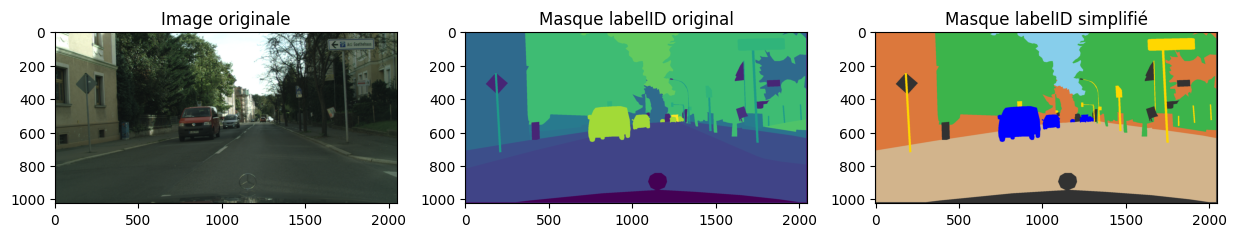

In [26]:
# Chargement d'une image et de son masque correspondant:

idx = 2830  # on peut tester différents indices
image_path = image_list[idx]
mask_path = mask_list[idx]

# Chargement de l'image
img = image.load_img(image_path)  # sans Resize
img = image.img_to_array(img) / 255.0  # Normalisation

# Chargement du masque
mask = image.load_img(mask_path, color_mode="grayscale")
mask = np.array(mask, dtype=np.uint8)  # Convertir directement en entier pour garder les 8 labels

mask_simplified = make_mask(mask) # Simplification du masque en 8 categs au lieu de 32;
mask_colorized = apply_color_map(mask_simplified) # Colorisation


# Affichage

print(f"Chemin de l'image : {image_path.relative_to(base_dir)}")

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(img)
ax[0].set_title("Image originale")
ax[1].imshow(mask)
ax[1].set_title("Masque labelID original")
ax[2].imshow(mask_colorized)
ax[2].set_title("Masque labelID simplifié")
plt.show()

## 2.2. Simplification categs et sauvegardes des masques en .npy

Étape	           Image	    Mask
Redimensionnement	✅ OUI	    ✅ OUI
Normalisation	    ✅ /255	❌ NON
Format final	(H, W, 3), float32	(H, W, 8), one-hot encodé

In [30]:
save_dir = Path(base_dir) /  "masks_npy"
mask_type = "_gtFine_labelIds"
mask_size = (256, 256)

process_and_save_masks(base_dir, mask_dir, save_dir, mask_type, mask_size)

Processing masks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3475/3475 [00:35<00:00, 97.90it/s]


## 2.3. Data augmentation

In [27]:
# Définition des transformations pour l'augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(10, 50), p=0.2),
    A.CoarseDropout(max_holes=5, max_height=50, max_width=50, p=0.3),
], additional_targets={'mask': 'mask'})

C:\Users\flore\Openclassrooms\Projet 8\envP8\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\flore\AppData\Local\Temp\ipykernel_15052\1742639297.py:8: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.2),
C:\Users\flore\AppData\Local\Temp\ipykernel_15052\1742639297.py:9: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=5, max_height=50, max_width=50, p=0.3),


In [28]:
# Dossiers source & destination
base_dir = Path("C:/Users/flore/Openclassrooms/Projet 8/data")
image_dir = base_dir / "original" / "images"
mask_dir = base_dir / "original" / "masks"
augmented_dir = base_dir / "augmented"

In [29]:
# paramétrages:
mask_type = "_gtFine_labelIds"
target_size = (256, 256)

Applique une augmentation aux images et leurs masques, enregistre l'image augmentée en PNG et le masque en .npy.
Resize (256,256) APRES l'augmentation pour éviter la perte d'information. resize permet de passer au modele des images légères

In [30]:
# Liste des images
image_paths = get_image_paths(image_dir)

for image_path in tqdm.tqdm(image_paths, desc="Processing images & masks"):
    try:

        # 1. Load de l'image
        # -----------------------------------
        
        # Déterminer le sous-dossier (train ou val)
        relative_path = image_path.relative_to(image_dir)
        subdir = relative_path.parent  # Ex: train ou val

        # Vérification si le masque existe bien pour l'image donnée
        mask_relative_path = image_path.relative_to(image_dir)  # Récupération du chemin relatif
        mask_name = image_path.stem.replace("_leftImg8bit", "") # récupération du nom de base sans `_leftImg8bit`
        mask_path = mask_dir / mask_relative_path.parent / f"{mask_name}_gtFine_labelIds.png"

        if not mask_path.exists():
            print(f"Masque non trouvé pour {image_path.name}, passage...")
            continue

        # Chargement de l'image et du masque sans redimensionnement
        img = image.load_img(image_path)  # Chargement en RGB, taille originale
        mask = image.load_img(mask_path, color_mode="grayscale")  # Chargement en niveaux de gris

        img = np.array(img)
        mask = np.array(mask, dtype=np.uint8)  # Convertir en tableau NumPy

        # Vérification que tout est OK
        if img is None or mask is None:
            print(f"Problème de chargement pour {image_path.name}, passage...")
            continue


        # 2. AUGMENTATION & RESIZE
        # -----------------------------------
        
        # Appliquer l'augmentation aux images et aux masques
        augmentation = transform(image=img, mask=mask)
        image_aug, mask_aug = augmentation["image"], augmentation["mask"]

        # Resize après augmentation
        image_aug = cv2.resize(image_aug, target_size, interpolation=cv2.INTER_LINEAR)
        mask_aug = cv2.resize(mask_aug, target_size, interpolation=cv2.INTER_NEAREST)

        # Simplification des catégories du masque (ex: de 34 à 8 classes)
        mask_simplified = make_mask(mask_aug)


        # 3. Sauvegarde:
        # -----------------------------------
        
        # Construire les chemins de sauvegarde
        save_image_subdir = augmented_dir / "images" / subdir
        save_mask_subdir = augmented_dir / "masks_npy" / subdir  # Stockage des masques en .npy ici

        # Création des dossiers parents si nécessaire
        save_image_subdir.mkdir(parents=True, exist_ok=True)
        save_mask_subdir.mkdir(parents=True, exist_ok=True)

        # Définition des chemins finaux des fichiers sauvegardés
        save_image_path = save_image_subdir / f"{image_path.stem}.png"
        save_mask_path = save_mask_subdir / f"{mask_name}_gtFine_labelIds.npy"

        # Sauvegarde des fichiers
        cv2.imwrite(str(save_image_path), image_aug)
        np.save(save_mask_path, mask_simplified, allow_pickle=False)

    except Exception as e:
        print(f"Erreur sur {image_path.name} : {e}")

print("Augmentation terminée !")

Processing images & masks: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 3475/3475 [07:42<00:00,  7.52it/s]

Augmentation terminée !


# 3. DataGenerator

le DataGenerator est un script python sauvegardé dans le meme dossier que ce notebook

In [31]:
from DataGenerator import DataGenerator

# paramétrage
batch_size = 32
img_size=(256, 256)

# chemins d'accès (uniquement avec les images d'origines):
base_dir = Path("C:/Users/flore/Openclassrooms/Projet 8/data/original")
train_image_dir = base_dir / "images" / "train"
train_mask_dir = base_dir / "masks_npy"/ "train"
val_image_dir = base_dir / "images" / "val"
val_mask_dir = base_dir / "masks_npy"/ "val"

train_image_paths = get_image_paths (train_image_dir)
train_mask_paths = get_mask_paths (train_mask_dir)
val_image_paths = get_image_paths (val_image_dir)
val_mask_paths = get_mask_paths (val_mask_dir)


# Chemins d'accès images d'origine + images augmentées:
aug_base_dir = Path("C:/Users/flore/Openclassrooms/Projet 8/data/augmented")
aug_train_image_dir = aug_base_dir / "images" / "train"
aug_train_mask_dir = aug_base_dir / "masks_npy"/ "train"
aug_val_image_dir = aug_base_dir / "images" / "val"
aug_val_mask_dir = aug_base_dir / "masks_npy"/ "val"

aug_train_image_paths = train_image_paths + get_image_paths (aug_train_image_dir)
aug_train_mask_paths = train_mask_paths + get_mask_paths (aug_train_mask_dir)
aug_val_image_paths = val_image_paths + get_image_paths (aug_val_image_dir)
aug_val_mask_paths = val_mask_paths + get_mask_paths (aug_val_mask_dir)


In [32]:
# Instanciation du générateur

train_generator = DataGenerator(
    image_paths=train_image_paths,
    mask_paths=train_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=True
)

val_generator = DataGenerator(
    image_paths=val_image_paths,
    mask_paths=val_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=False
)

Vérification du bon fonctionnement du DataGenerator:

In [33]:
print("Taille des images train :", len(train_generator.image_paths))
print("Taille des masques train :", len(train_generator.mask_paths))
print("Taille des images val :", len(val_generator.image_paths))
print("Taille des masques val :", len(val_generator.mask_paths))

Taille des images train : 2975
Taille des masques train : 2975
Taille des images val : 500
Taille des masques val : 500


In [34]:
print(train_generator.image_paths[2500])
print(train_generator.mask_paths[2500])

print(val_generator.image_paths[405])
print(val_generator.mask_paths[405])

C:\Users\flore\Openclassrooms\Projet 8\data\original\images\train\tubingen\tubingen_000028_000019_leftImg8bit.png
C:\Users\flore\Openclassrooms\Projet 8\data\original\masks_npy\train\tubingen\tubingen_000028_000019_gtFine_labelIds.npy
C:\Users\flore\Openclassrooms\Projet 8\data\original\images\val\munster\munster_000079_000019_leftImg8bit.png
C:\Users\flore\Openclassrooms\Projet 8\data\original\masks_npy\val\munster\munster_000079_000019_gtFine_labelIds.npy


In [35]:
#Test du data generator
# Récupérer un batch
X, Y = train_generator[0]

# Vérifier les formes des données
print("Shape des images :", X.shape)  # Doit être (batch_size, img_size, img_size, 3)
print("Shape des masques :", Y.shape)  # Si one-hot activé : (batch_size, img_size, img_size)

Shape des images : (32, 256, 256, 3)
Shape des masques : (32, 256, 256)


In [36]:
# Instanciation du générateur avec les images augmentées

aug_train_generator = DataGenerator(
    image_paths=aug_train_image_paths,
    mask_paths=aug_train_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=True
)

aug_val_generator = DataGenerator(
    image_paths=aug_val_image_paths,
    mask_paths=aug_val_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=False
)

In [37]:
print("Taille des images aug train :", len(aug_train_generator.image_paths))
print("Taille des masques aug train :", len(aug_train_generator.mask_paths))
print("Taille des images aug val :", len(aug_val_generator.image_paths))
print("Taille des masques aug val :", len(aug_val_generator.mask_paths))

Taille des images aug train : 5950
Taille des masques aug train : 5950
Taille des images aug val : 1000
Taille des masques aug val : 1000


In [38]:
print(aug_train_generator.image_paths[5500])
print(aug_train_generator.mask_paths[5500])

print(aug_val_generator.image_paths[899])
print(aug_val_generator.mask_paths[899])

C:\Users\flore\Openclassrooms\Projet 8\data\augmented\images\train\tubingen\tubingen_000053_000019_leftImg8bit.png
C:\Users\flore\Openclassrooms\Projet 8\data\augmented\masks_npy\train\tubingen\tubingen_000053_000019_gtFine_labelIds.npy
C:\Users\flore\Openclassrooms\Projet 8\data\augmented\images\val\munster\munster_000073_000019_leftImg8bit.png
C:\Users\flore\Openclassrooms\Projet 8\data\augmented\masks_npy\val\munster\munster_000073_000019_gtFine_labelIds.npy


# 4.Modeles

## 4.1 U-Net Mini

### 4.1 Definition modele

In [43]:
# def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal", dropout=False):
#     """Bloc convolutionnel avec BatchNorm et Dropout optionnel"""
#     x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(tensor)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     if dropout:
#         x = layers.Dropout(0.5)(x)
#     return x

# def unet_mini(input_shape=(128, 128, 3), num_classes=8):
#     inputs = layers.Input(input_shape)

#     # --- ENCODER ---
#     x1 = conv_block(inputs, 32)  # 128x128
#     p1 = layers.MaxPooling2D((2, 2))(x1)  # 64x64

#     x2 = conv_block(p1, 64)
#     p2 = layers.MaxPooling2D((2, 2))(x2)  # 32x32

#     # --- BOTTLENECK ---
#     b = conv_block(p2, 128, dropout=True)  # 32x32

#     # --- DECODER ---
#     u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(b)  # 32x32 -> 64x64
#     u2 = layers.Concatenate()([u2, x2])
#     u2 = conv_block(u2, 64, dropout=True)

#     u3 = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(u2)  # 64x64 -> 128x128
#     u3 = layers.Concatenate()([u3, x1])
#     u3 = conv_block(u3, 32, dropout=True)

#     # --- OUTPUT ---
#     outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(u3)

#     model = models.Model(inputs, outputs)
#     return model
    
# # Création du modèle
# model = unet_mini()
# model.summary()

In [44]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal", dropout=False):
    """Bloc convolutionnel avec BatchNorm et Dropout optionnel"""
    x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    if dropout:
        x = layers.Dropout(0.5)(x)
    return x

def unet_mini(input_shape=(256, 256, 3), num_classes=8):
    inputs = layers.Input(input_shape)

    # --- ENCODER ---
    x1 = conv_block(inputs, 32)  # 256x256
    p1 = layers.MaxPooling2D((2, 2))(x1)  # 128x128

    x2 = conv_block(p1, 64)  
    p2 = layers.MaxPooling2D((2, 2))(x2)  # 64x64

    x3 = conv_block(p2, 128)  
    p3 = layers.MaxPooling2D((2, 2))(x3)  # 32x32

    # --- BOTTLENECK ---
    b = conv_block(p3, 256, dropout=True)  # 32x32

    # --- DECODER ---
    u1 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(b)  # 32x32 -> 64x64
    u1 = layers.Concatenate()([u1, x3])
    u1 = conv_block(u1, 128, dropout=True)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(u1)  # 64x64 -> 128x128
    u2 = layers.Concatenate()([u2, x2])
    u2 = conv_block(u2, 64, dropout=True)

    u3 = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(u2)  # 128x128 -> 256x256
    u3 = layers.Concatenate()([u3, x1])
    u3 = conv_block(u3, 32, dropout=True)

    # --- OUTPUT ---
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(u3) 

    model = models.Model(inputs, outputs)
    return model

# Création du modèle
model = unet_mini()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256, 256, 32)      │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 256, 256, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 32)      │           9,248 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256, 256, 32)      │             128 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 256, 256, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 32)      │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128, 128, 64)      │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 128, 128, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 128, 128, 64)      │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 128, 128, 64)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 64)        │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │               

 Total params: 2,146,504 (8.19 MB)

 Trainable params: 2,143,688 (8.18 MB)

 Non-trainable params: 2,816 (11.00 KB)

### 4.1.2 Sans data augmentation

In [42]:
log_dir = Path("C:/Users/flore/Openclassrooms/Projet 8/logs/fit/" ) # Répertoire pour les logs de TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) #initialisation du callback tensorboard

In [46]:
print(multiprocessing.cpu_count())  # Nombre total de cœurs logiques

12


In [47]:
# paramétrages
epochs=30
checkpoint_path = "models/unet_mini.keras"

C:\Users\flore\Openclassrooms\Projet 8\envP8\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 1.4573 - mean_iou: 0.2368   
Epoch 1: val_loss improved from inf to 3.07274, saving model to models/unet_mini.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 1164s 12s/step - loss: 1.4537 - mean_iou: 0.2378 - val_loss: 3.0727 - val_mean_iou: 0.2094 - learning_rate: 0.0010
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 0.7356 - mean_iou: 0.4652   
Epoch 2: val_loss improved from 3.07274 to 1.44911, saving model to models/unet_mini.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 1116s 12s/step - loss: 0.7352 - mean_iou: 0.4653 - val_loss: 1.4491 - val_mean_iou: 0.2904 - learning_rate: 0.0010
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 0.6101 - mean_iou: 0.5142   
Epoch 3: val_loss improved from 1.44911 to 0.97673, saving model to models/unet_mini.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 1128s 12s/step - loss: 0.6100 - mean_iou: 0.5142 - val_loss: 0.9767 - val_mean_iou: 0.3934 - learning_rate: 0.0010
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12s

2025/03/11 22:14:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/11 22:14:23 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\flore\AppData\Local\Temp\tmp2ybul9ky\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/03/11 22:14:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Nombre d'images utilisées: 512
Mean IoU: 0.602
IoU par classe: [0.55 0.87 0.71 0.   0.8  0.84 0.33 0.72]
Mean Dice: 0.7

Valeurs uniques dans test_mask: [0 1 2 3 4 5 6 7]
Valeurs uniques dans y_pred_class: [0 1 2 4 5 6 7]
Répartition dans test_mask: [ 4776386 12466944  6724278   671393  5195917   962931   433229  2323354]
Répartition dans y_pred_class: [ 2659521 13792184  8663172  4686022   911917   387726  2453890]


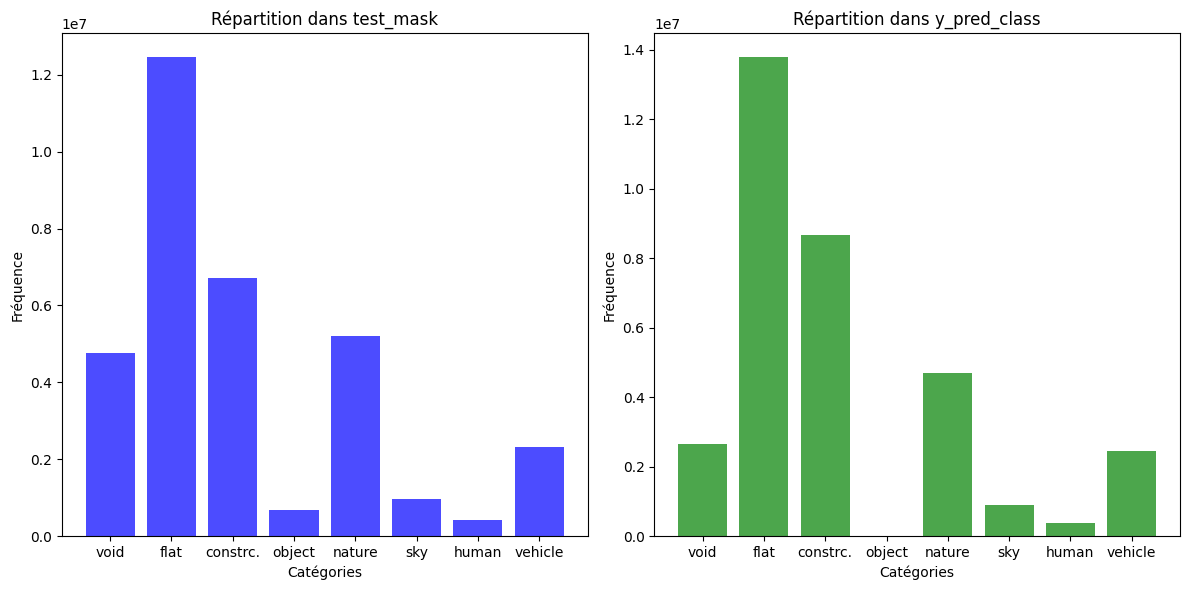

🏃 View run U-Net Mini sans data augm. at: http://127.0.0.1:5000/#/experiments/615947391303416845/runs/84f48ef7b5aa44c8bdf36d8e9b0f052b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/615947391303416845


In [48]:
with mlflow.start_run(run_name="U-Net Mini sans data augm."):

    #mlflow.set_tag("Approach", "sans data augm.")

    #----------------------------
    # Hyperparamètres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des paramètres


    #----------------------------
    # Compile & entraînement
    history = train_pipeline(model, params, train_generator, val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du modèle dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, "U_Net_Mini") #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du modèle dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step


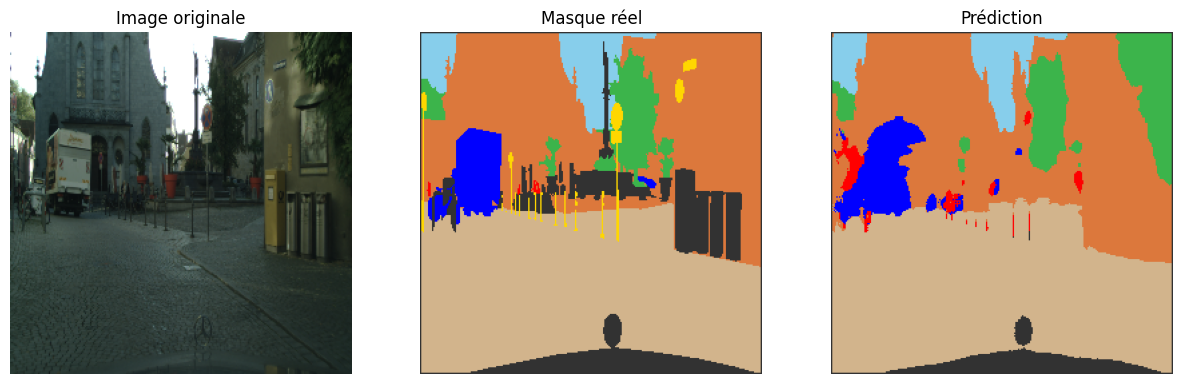

In [49]:
# Sélection d'une image test pour visualitation
batch_index = 9
img_nb = 2

visualisation_img_test (model, batch_index, img_nb)

### 4.1.3 Avec data augmentation

In [50]:
# paramétrages
epochs=30
checkpoint_path = "models/unet_mini_aug.keras"

Epoch 1/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 0.7679 - mean_iou: 0.4650   
Epoch 1: val_loss improved from inf to 0.72819, saving model to models/unet_mini_aug.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 2384s 13s/step - loss: 0.7674 - mean_iou: 0.4651 - val_loss: 0.7282 - val_mean_iou: 0.4840 - learning_rate: 0.0010
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - loss: 0.5775 - mean_iou: 0.5335   
Epoch 2: val_loss did not improve from 0.72819
185/185 ━━━━━━━━━━━━━━━━━━━━ 2527s 14s/step - loss: 0.5775 - mean_iou: 0.5335 - val_loss: 0.8387 - val_mean_iou: 0.4710 - learning_rate: 0.0010
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 0.5401 - mean_iou: 0.5525   
Epoch 3: val_loss improved from 0.72819 to 0.60776, saving model to models/unet_mini_aug.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 2196s 12s/step - loss: 0.5401 - mean_iou: 0.5525 - val_loss: 0.6078 - val_mean_iou: 0.5300 - learning_rate: 0.0010
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 0.5223 -

2025/03/12 02:39:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/12 02:39:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\flore\AppData\Local\Temp\tmp95a9rvwb\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/03/12 02:39:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Nombre d'images utilisées: 512
Mean IoU: 0.612
IoU par classe: [0.71 0.89 0.71 0.   0.81 0.8  0.32 0.64]
Mean Dice: 0.708

Valeurs uniques dans test_mask: [0 1 2 3 4 5 6 7]
Valeurs uniques dans y_pred_class: [0 1 2 4 5 6 7]
Répartition dans test_mask: [ 4776386 12466944  6724278   671393  5195917   962931   433229  2323354]
Répartition dans y_pred_class: [ 3539577 12777056  7855930  5175222   978116   702943  2525588]


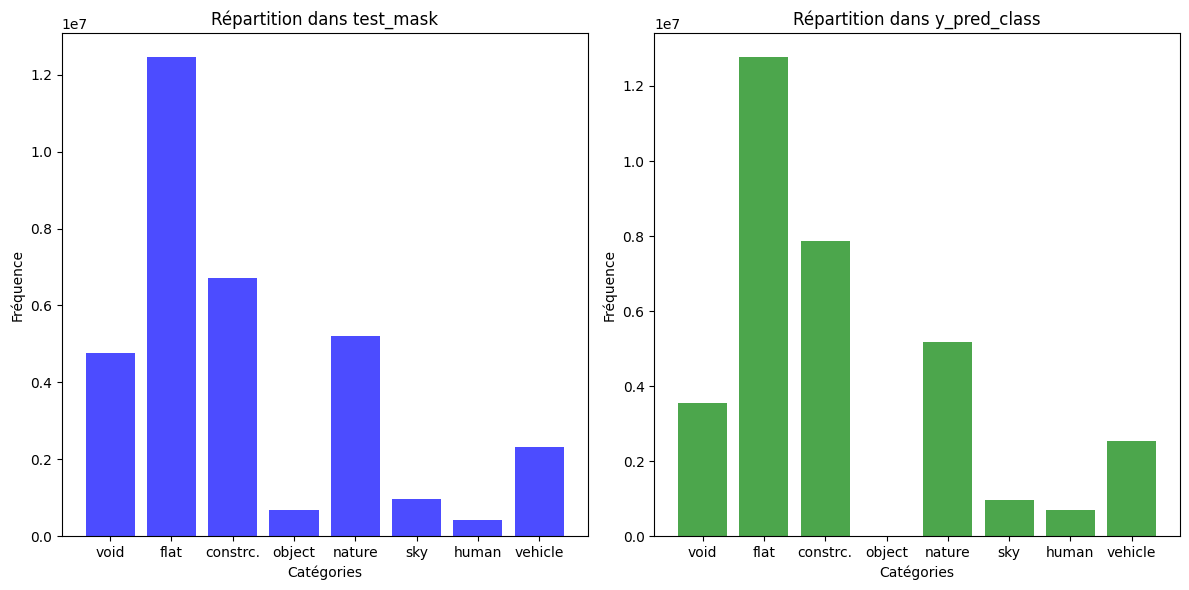

🏃 View run U-Net Mini avec data augm. at: http://127.0.0.1:5000/#/experiments/615947391303416845/runs/703d88d382c84cce8a424b528ab7c4ef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/615947391303416845


In [51]:
with mlflow.start_run(run_name="U-Net Mini avec data augm."):

    #mlflow.set_tag("Approach", "avc data augm.")

    #----------------------------
    # Hyperparamètres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des paramètres


    #----------------------------
    # Compile & entraînement
    history = train_pipeline(model, params, aug_train_generator, aug_val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du modèle dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, "U_Net_Mini_Aug") #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du modèle dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


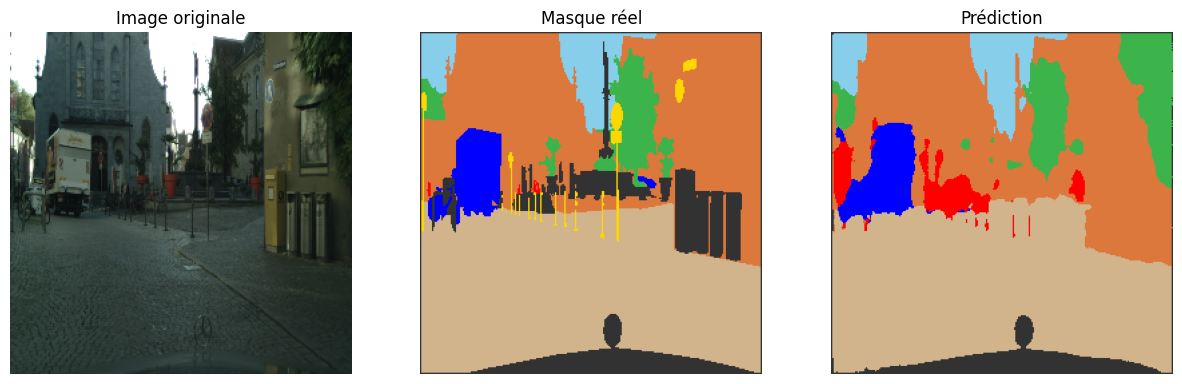

In [52]:
# Sélection d'une image test pour visualitation
batch_index = 9
img_nb = 2

visualisation_img_test (model, batch_index, img_nb)

## 4.2 VGG16-U-Net

### 4.1 Definition modèle

In [53]:
# def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal", dropout=False):
#     """Bloc convolutionnel avec BatchNorm et Dropout optionnel"""
#     x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(tensor)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     if dropout:
#         x = layers.Dropout(0.5)(x)
#     return x

# def unet_vgg16(input_shape=(128, 128, 3), num_classes=8):
#     inputs = layers.Input(input_shape)

#     # --- ENCODER : Utilisation de VGG16 pré-entrainé sans la couche top (classification) ---
#     vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=inputs)
#     vgg16.trainable = False  # On garde les poids de VGG16 fixes

#     # Utilisation des sorties de VGG16 pour notre encodeur
#     x1 = vgg16.get_layer("block1_conv2").output  # 128x128
#     x2 = vgg16.get_layer("block2_conv2").output  # 64x64
#     x3 = vgg16.get_layer("block3_conv3").output  # 32x32
#     x4 = vgg16.get_layer("block4_conv3").output  # 16x16

#     # --- BOTTLENECK ---
#     b = conv_block(x4, 512, dropout=True)  # 16x16

#     # --- DECODER ---
#     u4 = layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same')(b)  # 16x16 -> 32x32
#     u4 = layers.Concatenate()([u4, x3])
#     u4 = conv_block(u4, 256, dropout=True)

#     u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(u4)  # 32x32 -> 64x64
#     u3 = layers.Concatenate()([u3, x2])
#     u3 = conv_block(u3, 128, dropout=True)

#     u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(u3)  # 64x64 -> 128x128
#     u2 = layers.Concatenate()([u2, x1])
#     u2 = conv_block(u2, 64, dropout=True)

#     # --- OUTPUT ---
#     outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(u2)

#     model = models.Model(inputs, outputs)
#     return model

# # Création du modèle avec VGG16 comme encodeur
# model = unet_vgg16()
# model.summary()

In [39]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal", dropout=False):
    """Bloc convolutionnel avec BatchNorm et Dropout optionnel"""
    x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    if dropout:
        x = layers.Dropout(0.5)(x)
    return x

def unet_vgg16(input_shape=(256, 256, 3), num_classes=8):
    inputs = layers.Input(input_shape)

    # --- ENCODER : Utilisation de VGG16 pré-entrainé sans la couche top (classification) ---
    vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=inputs)
    vgg16.trainable = False  # On garde les poids de VGG16 fixes

    # Utilisation des sorties de VGG16 pour notre encodeur
    x1 = vgg16.get_layer("block1_conv2").output  # 256x256
    x2 = vgg16.get_layer("block2_conv2").output  # 128x128
    x3 = vgg16.get_layer("block3_conv3").output  # 64x64
    x4 = vgg16.get_layer("block4_conv3").output  # 32x32

    # --- BOTTLENECK ---
    b = conv_block(x4, 512, dropout=True)  # 32x32

    # --- DECODER ---
    u4 = layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same')(b)  # 32x32 -> 64x64
    u4 = layers.Concatenate()([u4, x3])
    u4 = conv_block(u4, 256, dropout=True)

    u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(u4)  # 64x64 -> 128x128
    u3 = layers.Concatenate()([u3, x2])
    u3 = conv_block(u3, 128, dropout=True)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(u3)  # 128x128 -> 256x256
    u2 = layers.Concatenate()([u2, x1])
    u2 = conv_block(u2, 64, dropout=True)

    # --- OUTPUT ---
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(u2)

    model = models.Model(inputs, outputs)
    return model

# Création du modèle avec VGG16 comme encodeur pour 256x256
model = unet_vgg16(input_shape=(256, 256, 3))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 256, 256, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 256, 256, 64)      │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 128, 128, 64)      │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 128, 128, 128)     │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 128, 128, 128)     │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 64, 64, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 64, 64, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 64, 64, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 64, 64, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 32, 32, 256)       │               0 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 32, 32, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 32, 32, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 32, 32, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 512)       │       2,359,808 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 32, 512)       │           2,048 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 32, 32, 512)       │               

 Total params: 16,235,144 (61.93 MB)

 Trainable params: 8,596,040 (32.79 MB)

 Non-trainable params: 7,639,104 (29.14 MB)

### 4.2.2 Sans data augmentation

In [40]:
# paramétrages
epochs=30
checkpoint_path = "models/VGG16_unet.keras"

In [ ]:
with mlflow.start_run(run_name="VGG16 U-Net sans data augm."):

    #mlflow.set_tag("Approach", "sans data augm.")

    #----------------------------
    # Hyperparamètres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des paramètres


    #----------------------------
    # Compile & entraînement
    history = train_pipeline(model, params, train_generator, val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du modèle dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, "VGG16_UNet") #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du modèle dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

C:\Users\flore\Openclassrooms\Projet 8\envP8\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


In [ ]:
# Sélection d'une image test pour visualitation
batch_index = 9
img_nb = 2

visualisation_img_test (model, batch_index, img_nb)

### 4.2.3 Avec data augmentation

In [ ]:
# paramétrages
epochs=30
checkpoint_path = "models/VGG16_unet_aug.keras"

In [ ]:
with mlflow.start_run(run_name="VGG16 U-Net avec data augm."):

    #mlflow.set_tag("Approach", "avec data augm.")

    #----------------------------
    # Hyperparamètres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des paramètres


    #----------------------------
    # Compile & entraînement
    history = train_pipeline(model, params, aug_train_generator, aug_val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du modèle dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, "VGG16_UNet_Aug") #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du modèle dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

In [ ]:
# Sélection d'une image test pour visualitation
batch_index = 9
img_nb = 2

visualisation_img_test (model, batch_index, img_nb)

## 4.3 ResNet 50

### 4.1 Definition modèle

ResNet50 comme encodeur

On charge ResNet50 sans la partie fully connected (include_top=False).
On récupère des couches clés (conv1_relu, conv2_block3_out, ...) pour le skip connections de U-Net.
Par défaut, on gèle les poids de ResNet pour éviter d’écraser ses features.
Bottleneck

On prend la dernière couche convolutive du ResNet avant de décompresser les features.
Décodeur (Decoder)

Chaque bloc du décodeur utilise Conv2DTranspose (upsampling) suivi de concaténation avec les features du ResNet.
On garde la même structure que ton U-Net mini, mais en partant d’un encodeur plus puissant.
Sortie (Output Layer)

Conv2D(num_classes, (1,1), activation="softmax") pour segmentation multi-classes.

In [ ]:
def resnet_unet(input_shape=(224, 224, 3), num_classes=8, fine_tune=False):
    inputs = layers.Input(input_shape)

    # Préprocessing des images pour ResNet
    x = applications.resnet50.preprocess_input(inputs)

    # Charger ResNet50 pré-entraîné sur ImageNet sans les couches fully connected
    base_model = applications.ResNet50(weights="imagenet", include_top=False, input_tensor=x)
    
    # Geler les poids du backbone sauf si fine-tuning activé
    if not fine_tune:
        base_model.trainable = False
    else:
        # Dégeler les 10 dernières couches du ResNet pour qu'elles continuent d'apprendre sur le dataset.
        for layer in base_model.layers[-10:]:  # Dernières 10 couches
            layer.trainable = True
            
    # Extraction des features maps
    x1 = base_model.get_layer("conv1_relu").output  # 112x112
    x2 = base_model.get_layer("conv2_block3_out").output  # 56x56
    x3 = base_model.get_layer("conv3_block4_out").output  # 28x28
    x4 = base_model.get_layer("conv4_block6_out").output  # 14x14
    b = base_model.get_layer("conv5_block3_out").output  # 7x7

    # DECODER (Upsampling + Concatenation)
    u4 = layers.Conv2DTranspose(512, (3,3), strides=2, padding="same")(b)
    u4 = layers.Concatenate()([u4, x4])
    u4 = layers.Conv2D(512, (3,3), activation="relu", padding="same")(u4)

    u3 = layers.Conv2DTranspose(256, (3,3), strides=2, padding="same")(u4)
    u3 = layers.Concatenate()([u3, x3])
    u3 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(u3)

    u2 = layers.Conv2DTranspose(128, (3,3), strides=2, padding="same")(u3)
    u2 = layers.Concatenate()([u2, x2])
    u2 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(u2)

    u1 = layers.Conv2DTranspose(64, (3,3), strides=2, padding="same")(u2)
    u1 = layers.Concatenate()([u1, x1])  
    u1 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(u1)

    u0 = layers.Conv2DTranspose(32, (3,3), strides=2, padding="same")(u1)
    u0 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(u0)

    outputs = layers.Conv2D(num_classes, (1,1), activation="softmax")(u0)

    model = models.Model(inputs, outputs)
    return model

# Création du modèle
model = resnet_unet()
model.summary()

### 4.2.2 Sans data augmentation

In [ ]:
# paramétrages
epochs=30
checkpoint_path = "models/ResNet.keras"

In [ ]:
img_size=(224,224)

# Instanciation du générateur

train_generator = DataGenerator(
    image_paths=train_image_paths,
    mask_paths=train_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=True
)

val_generator = DataGenerator(
    image_paths=val_image_paths,
    mask_paths=val_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=False
)

In [ ]:
with mlflow.start_run(run_name="Resnet sans data augm."):

    #mlflow.set_tag("Approach", "sans data augm.")

    #----------------------------
    # Hyperparamètres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des paramètres


    #----------------------------
    # Compile & entraînement
    history = train_pipeline(model, params, train_generator, val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du modèle dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, "ResNet") #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du modèle dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

In [ ]:
# Sélection d'une image test pour visualitation
batch_index = 9
img_nb = 2

visualisation_img_test (model, batch_index, img_nb)

### 4.2.3 Avec data augmentation

In [ ]:
# Instanciation du générateur avec les images augmentées

img_size=(224,224)

aug_train_generator = DataGenerator(
    image_paths=aug_train_image_paths,
    mask_paths=aug_train_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=True
)

aug_val_generator = DataGenerator(
    image_paths=aug_val_image_paths,
    mask_paths=aug_val_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=False
)

In [ ]:
# paramétrages
epochs=30
checkpoint_path = "models/ResNet_aug.keras"

In [ ]:
with mlflow.start_run(run_name="ResNet avec data augm."):

    #mlflow.set_tag("Approach", "avec data augm.")

    #----------------------------
    # Hyperparamètres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des paramètres


    #----------------------------
    # Compile & entraînement
    history = train_pipeline(model, params, aug_train_generator, aug_val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du modèle dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, "ResNet_Aug") #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du modèle dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

In [ ]:
# Sélection d'une image test pour visualitation
batch_index = 9
img_nb = 2

visualisation_img_test (model, batch_index, img_nb)

## 2.3. Simplification categs et sauvegardes des masques en .npy

### 4.1 Regression log avec CountVectorizer

CountVectorizer	convertit le texte en une matrice d'occurrences de mots.	
* **Avantages**: Simple, rapide à exécuter, efficace pour des vocabulaires réduits.	
* **Inconvénients**: Ne capture pas la sémantique ou l'ordre des mots ; sensible à la taille du vocabulaire.

Definition du modèle: une regression logistique, sans hyper-parmètres de départ. Ils seront ensuite affinés via l'optimisation des hyperparamètres (grid_searchCV)

In [70]:
with mlflow.start_run(run_name="Log Reg with CountVectorizer"):

    mlflow.set_tag("Approach", "CountVectorizer")

    #----------------------------
    # Hyperparamètres
    params = {
        "C": 1, #[0.01, 0.1, 1, 10, 100]
        "solver": 'lbfgs', #'newton-cg','lbfgs','liblinear', 'saga']
        "penalty": 'l2', #['l1', 'l2'], 
        "random_state": 42,
        "n_jobs": -1,
    }
    mlflow.log_params(params) #log des paramètres

    #----------------------------
    # Modèle et pipeline
    model = LogisticRegression(**params)
    pipeline = make_pipeline(
        CountVectorizer(stop_words='english', max_df=0.95, min_df=2), # Etape 1: transformation des features en vecteur
        model                                                         # Étape 2 : Modèle de regression logistique 
    )
    # pipeline = Pipeline([
    #     ('vectorizer', CountVectorizer(stop_words='english', max_df=0.95, min_df=2)), # Etape 1: transformation des features en vecteur
    #     ('model', model)                                      # Étape 2 : Modèle de regression logistique
    # ])
    
    # Log du pipeline
    mlflow.sklearn.log_model(pipeline, "LogReg_CountVectorizer")

    
    #----------------------------
    # Calcul de l'accuracy, sans rechercher le seuil optimal
    cv_scores_pipeline = cross_val_score(pipeline, data['sentence_bow_lem'], data['target'], cv=5, scoring='accuracy')
    # mlflow.log_metric("Accuracy sans seuil optimal", round(np.mean(cv_scores_pipeline),3))

    #----------------------------
    # Prédiction et métrics en recherchant le seuil optimal
    # Utilisation de 'predict_proba' pour obtenir les probabilités
    y_proba = cross_val_predict(pipeline, data['sentence_bow_lem'], data['target'], cv=5, method='predict_proba')
    results, conf_matrix = model_metrics(data['target'], y_proba)
    
    #logs des résultats dans MLflow:
    mlflow.log_metric("Accuracy", results['Accuracy'][-1])
    mlflow.log_metric("F1_Score", results['F1-score'][-1])
    mlflow.log_metric("Coût métier", results['Coût métier'][-1])
    mlflow.log_metric("FN", results['FN'][-1])
    mlflow.log_metric("FP", results['FP'][-1])

    #----------------------------
    # Matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Matrice de confusion avec seuil optimal")
    plt.xlabel("Prédictions")
    plt.ylabel("Vrais labels")
    
    # Enregistrement avant affichage
    plt.savefig("conf_matrix.png")
    mlflow.log_artifact("conf_matrix.png")
    
    plt.show()
    
        

🏃 View run Log Reg with CountVectorizer at: http://127.0.0.1:5000/#/experiments/615947391303416845/runs/5acd59f713624818811bd5acea0411be
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/615947391303416845


NameError: name 'LogisticRegression' is not defined

### 4.2  Regression log avec TF-IDF

TF-IDF = Term Frequency - Inverse Document Frequency
On pondère l'importance d'un mot dans un document, par rapport à l'ensemble du corpus (ici tous nos articles vendus sur le site e-com)

* **Avantages:** Meilleure différenciation entre les termes fréquents et rares, réduit l'impact des mots peu informatifs.
* **Inconvénients:** là encore, insensible à l'ordre et au contexte des mots ; dépend du corpus pour une bonne pondération.

In [ ]:
with mlflow.start_run(run_name="Log Reg with TF-IDF"):

    mlflow.set_tag("Approach", "TF-IDF")

    #----------------------------
    # Hyperparamètres
    params = {
        "C": 1, #[0.01, 0.1, 1, 10, 100]
        "solver": 'lbfgs', #'newton-cg','lbfgs','liblinear', 'saga']
        "penalty": 'l2', #['l1', 'l2'], 
        "random_state": 42,
        "n_jobs": -1,
    }
    mlflow.log_params(params) #log des paramètres

    #----------------------------
    # Modèle et pipeline
    model = LogisticRegression(**params)
    pipeline = make_pipeline(
        TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2), # Etape 1: transformation des features en vecteur
        model                                                         # Étape 2 : Modèle de regression logistique 
    )
    # Log du pipeline
    mlflow.sklearn.log_model(pipeline, "LogReg_TF_IDF")


    
    #----------------------------
    # Calcul de l'accuracy, sans rechercher le seuil optimal
    cv_scores_pipeline = cross_val_score(pipeline, data['sentence_bow_lem'], data['target'], cv=5, scoring='accuracy')
    # mlflow.log_metric("Accuracy sans seuil optimal", round(np.mean(cv_scores_pipeline),3))

    #----------------------------
    # Prédiction et métrics en recherchant le seuil optimal
    # Utilisation de 'predict_proba' pour obtenir les probabilités
    y_proba = cross_val_predict(pipeline, data['sentence_bow_lem'], data['target'], cv=5, method='predict_proba')
    results, conf_matrix = model_metrics(data['target'], y_proba)
    
    #logs des résultats dans MLflow:
    mlflow.log_metric("Accuracy", results['Accuracy'][-1])
    mlflow.log_metric("F1_Score", results['F1-score'][-1])
    mlflow.log_metric("Coût métier", results['Coût métier'][-1])
    mlflow.log_metric("FN", results['FN'][-1])
    mlflow.log_metric("FP", results['FP'][-1])

    #----------------------------
    # Matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Matrice de confusion avec seuil optimal")
    plt.xlabel("Prédictions")
    plt.ylabel("Vrais labels")
    
    # Enregistrement avant affichage
    plt.savefig("conf_matrix.png")
    mlflow.log_artifact("conf_matrix.png")
    
    plt.show()
    
        

# 5. Approche “Modèle sur mesure avancé”

Pour l'approche "modèle sur mesure avancé, nous allons utiliser différents réseaux profonds de neurones classique (DNN ou deep neural network) pour classifier les sentiments des tweets de facon binaire (positif ou negatif).
Nous allons tester 2 techniques d'embeddings, pour obtenir des vecteurs qui caractérisent chacun des tweets:
* Word2Vec
* FastText
Après le test de ces différents modèles couplés à Word2Vec et FastText, nous finirons en testant la performance de BERT.

## 5.1 DNN avec Word2Vec

Word2Vec apprend des représentations vectorielles denses pour les mots en utilisant des architectures de réseau neuronal (CBOW ou Skip-gram). 
Les mots proches dans l’espace vectoriel partagent des similarités contextuelles. 

* **Avantages:** Capture les relations sémantiques entre les mots, représentations continues adaptées aux modèles ML.
* **Inconvénients:** Nécessite un grand corpus pour des embeddings de qualité ; insensible aux structures complexes.

**DNN (Deep Neural Network)**

* Type : Réseau de neurones dense (Fully Connected)
  
* Caractéristiques :
Réseau simple avec des couches Dense (MLP - Multi-Layer Perceptron)
Relu pour l'activation des couches cachées, sigmoid pour la sortie (binaire)
Dropout et régularisation pour éviter l'overfitting

* C'est un empilement de couches de neurones connectés entre eux. Chaque neurone reçoit des nombres (features d'entrée), les transforme avec des calculs (poids + biais), applique une fonction d’activation (ex: ReLU) et envoie le résultat à la couche suivante.



In [ ]:
with mlflow.start_run(run_name="DNN with Word2Vec"):
    mlflow.set_tag("Approach", "Word2Vec + DNN")
    
    #-------------------------------------------------
    # 1. Paramétrage du modèle
    #-------------------------------------------------
    params = {
        # Word2Vec
        "vector_size": 100,     # Dimension des vecteurs
        "window": 5,     # Taille de la fenêtre contextuelle
        "min_count": 1,  # Ignore les mots rares
        "epochs": 50,   # Nombre d'itérations d'entraînement sur les données
        # DNN
        "dropout_rate": 0.3, #[None, 0.3, 0.5]
        "regularization": l2(0.01), #[None, l1(0.01), l2(0.01)] 
    }
    mlflow.log_params(params)

    #-------------------------------------------------
    # 2. Création du modèle Word2Vec sur l'ensemble du corpus
    #-------------------------------------------------
    
    tokenized_tweets = [text.split() for text in data['sentence_bow_lem']]
    
    w2v_model = Word2Vec(
        sentences=tokenized_tweets,
        vector_size=params["vector_size"],  
        window=params["window"],
        min_count=params["min_count"],
        epochs=params["epochs"],
        workers=10
    )

    # Sauvegarde du modèle Word2Vec dans MLflow
    w2v_model_path = "word2vec.model"
    w2v_model.save(w2v_model_path)
    mlflow.log_artifact(w2v_model_path, artifact_path="word2vec")
    
    #-------------------------------------------------
    # 3. Obtention des vecteurs pour chaque tweet
    #-------------------------------------------------
    
    def get_sentence_vector(sentence, model, dim):
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(dim)
    
    X = np.array([get_sentence_vector(text, w2v_model, params["vector_size"]) for text in tokenized_tweets])
    y = data['target'].reset_index(drop=True)

    #-------------------------------------------------
    # 4. Split en train/test (85/15)
    #-------------------------------------------------
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    #-------------------------------------------------
    # 5. Construction du modèle DNN
    #-------------------------------------------------
    
    # Modèle DNN
    model = Sequential([
        Input(shape=(params["vector_size"],)),
        Dense(64, activation='relu', kernel_regularizer=params["regularization"]),
        Dropout(params["dropout_rate"]),
        Dense(32, activation='relu', kernel_regularizer=params["regularization"]),
        Dropout(params["dropout_rate"]),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=TfAdam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    #-------------------------------------------------
    # 6. Entraînement du modèle & Prédiction
    #-------------------------------------------------
    
    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=16,
        validation_split=0.15,
        #verbose=0,
        callbacks=[early_stopping]
    )
    
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    #-------------------------------------------------
    # 7. Résultats 
    #-------------------------------------------------

    show_history(history)
    plot_history(history, path=f"training_history.png")
    plt.close()
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    cout_metier = fp + fn

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Matrice de confusion:\n", conf_matrix)
    print("Coût métier:", cout_metier)
    
    mlflow.log_metric("Accuracy", round(accuracy, 3))
    mlflow.log_metric("F1_Score", round(f1, 3))
    mlflow.log_metric("Coût métier", cout_metier)
    mlflow.log_metric("FN", fn)
    mlflow.log_metric("FP", fp)
    
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.keras.log_model(model, "DNN_Model", signature=signature)


## 5.2 DNN avec FastText

FastText est une technique d'embedding qui apprend des représentations vectorielles denses pour les mots en utilisant des architectures de réseau neuronal (CBOW ou Skip-gram). Contrairement à Word2Vec, il représente chaque mot comme une somme de vecteurs de sous-mots (n-grammes), ce qui permet une meilleure généralisation sur les mots rares ou inconnus. Les mots proches dans l’espace vectoriel partagent des similarités contextuelles et morphologiques.  

* **Avantages:** Capture les relations sémantiques et morphologiques entre les mots, gère mieux les mots rares ou inconnus, et améliore la robustesse aux fautes d’orthographe.  
* **Inconvénients:** Plus gourmand en mémoire et en calcul que Word2Vec ; nécessite un tuning des n-grammes pour de meilleurs résultats.

In [ ]:
with mlflow.start_run(run_name="DNN with FastText"):
    
    mlflow.set_tag("Approach", "FastText + DNN")
    
    #-------------------------------------------------
    # 1. Paramétrage du modèle
    #-------------------------------------------------
    
    params = {
        #FastText
        "vector_size": 100,     # Dimension des vecteurs
        "window": 5,     # Taille de la fenêtre contextuelle
        "min_count": 1,  # Ignore les mots rares
        "epochs": 100,   # Nombre d'itérations d'entraînement sur les données
        # DNN
        "dropout_rate": 0.3, #[None, 0.3, 0.5]
        "regularization": l2(0.01), #[None, l1(0.01), l2(0.01)] 
    }

    
    mlflow.log_params(params)
    
    # obtention des tweets tokenisés:
    tokenized_tweets = [text.split() for text in data['sentence_bow_lem']]
    
    #-------------------------------------------------
    # 2. Création du modèle FastText sur l'ensemble du corpus
    #-------------------------------------------------
    
    ft_model = FastText(
        sentences=tokenized_tweets,
        vector_size=params["vector_size"],  
        window=params["window"],
        min_count=params["min_count"],
        epochs=params["epochs"],
        workers=10
    )

    # Sauvegarde du modèle FastText dans MLflow an tant qu'artifact:
    ft_model_path = "fasttext.model"
    ft_model.save(ft_model_path)
    mlflow.log_artifact(ft_model_path, artifact_path="FastText")
    
    #-------------------------------------------------
    # 3. Obtention des vecteurs pour chaque tweet
    #-------------------------------------------------
    
    def get_sentence_vector(sentence, model, dim):
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

    
    X = np.array([get_sentence_vector(text, ft_model, params["vector_size"]) for text in tokenized_tweets])
    y = data['target'].reset_index(drop=True)
    
    #-------------------------------------------------
    # 4. Split en train/test (85/15)
    #-------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    # -------------------------------------------------
    # 5. Construction du modèle DNN
    # -------------------------------------------------
    model = Sequential([
        Input(shape=(params["vector_size"],)),
        Dense(64, activation='relu', kernel_regularizer=params["regularization"]),
        Dropout(params["dropout_rate"]),
        Dense(32, activation='relu', kernel_regularizer=params["regularization"]),
        Dropout(params["dropout_rate"]),
        Dense(1, activation='sigmoid')
    ])
        
    # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=TfAdam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    #-------------------------------------------------
    # 6. Entraînement du modèle & Prédiction
    #-------------------------------------------------
    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=16,
        validation_split=0.15,
        #verbose=0,
        callbacks=[early_stopping]
    )
    
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    #-------------------------------------------------
    # 7. Résultats 
    #-------------------------------------------------

    show_history(history)
    plot_history(history, path=f"training_history.png")
    plt.close()
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    tn, fp, fn, tp = conf_matrix.ravel()
    cout_metier = fp + fn
    
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Matrice de confusion:\n", conf_matrix)
    print("Coût métier:", cout_metier)
    
    # Logs des résultats dans MLflow
    mlflow.log_metric("Accuracy", round(accuracy, 3))
    mlflow.log_metric("F1_Score", round(f1, 3))
    mlflow.log_metric("Coût métier", cout_metier)
    mlflow.log_metric("FN", fn)
    mlflow.log_metric("FP", fp)
    
    # Enregistrement du modèle DNN dans MLflow
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.keras.log_model(model, "DNN_Model", signature=signature)


## 5.3 CNN avec FastText

**CNN (Convolutional Neural Network)**

* Type : Réseau de neurones convolutionnel (1D)
  
* Caractéristiques : Conv1D applique des filtres pour capturer des patterns locaux dans les séquences
MaxPooling réduit la dimension tout en conservant les informations importantes
Flatten transforme les sorties convolutives en un vecteur pour la classification
Relu pour l'activation, sigmoid pour la sortie binaire.

* Au lieu de tout connecter comme un DNN, un CNN applique des filtres (Conv1D) qui glissent sur l’entrée (ex: un texte). Ces filtres repèrent des motifs récurrents comme des mots-clés ou des groupes de mots. Ensuite, le max-pooling réduit la taille tout en gardant l’essentiel.

In [ ]:
with mlflow.start_run(run_name="CNN with FastText"):
    
    mlflow.set_tag("Approach", "FastText + CNN")
    
    #-------------------------------------------------
    # 1. Paramétrage du modèle
    #-------------------------------------------------
    
    params = {
        #FastText
        "vector_size": 100,     # Dimension des vecteurs
        "window": 5,     # Taille de la fenêtre contextuelle
        "min_count": 1,  # Ignore les mots rares
        "epochs": 100,   # Nombre d'itérations d'entraînement sur les données
        # CNN
        "dropout_rate": 0.3, #[None, 0.3, 0.5]
        "regularization": l2(0.01), #[None, l1(0.01), l2(0.01)] 
    }
    
    mlflow.log_params(params)
    
    # obtention des tweets tokenisés:
    tokenized_tweets = [text.split() for text in data['sentence_bow_lem']]
    
    #-------------------------------------------------
    # 2. Création du modèle FastText sur l'ensemble du corpus
    #-------------------------------------------------
    
    ft_model = FastText(
        sentences=tokenized_tweets,
        vector_size=params["vector_size"],  
        window=params["window"],
        min_count=params["min_count"],
        epochs=params["epochs"],
        workers=10
    )
    
    # Sauvegarde du modèle FastText dans MLflow an tant qu'artifact:
    ft_model_path = "fasttext.model"
    ft_model.save(ft_model_path)
    mlflow.log_artifact(ft_model_path, artifact_path="FastText")
    
    #-------------------------------------------------
    # 3. Obtention des vecteurs pour chaque tweet
    #-------------------------------------------------
    
    def get_sentence_vector(sentence, model, dim):
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(dim)
    
    X = np.array([get_sentence_vector(text, ft_model, params["vector_size"]) for text in tokenized_tweets])
    y = data['target'].reset_index(drop=True)
    
    #-------------------------------------------------
    # 4. Split en train/test (85/15)
    #-------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    
    # -------------------------------------------------
    # 5. Construction du modèle CNN
    # -------------------------------------------------
    model = Sequential([
        Input(shape=(params["vector_size"], 1)),  # Ajout d'une dimension pour les filtres CNN
        Conv1D(64, 5, activation='relu', kernel_regularizer=params["regularization"]),
        MaxPooling1D(pool_size=2),
        Dropout(params["dropout_rate"]),
        Conv1D(32, 5, activation='relu', kernel_regularizer=params["regularization"]),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=TfAdam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    #-------------------------------------------------
    # 6. Entraînement du modèle & Prédiction
    #-------------------------------------------------
    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=16,
        validation_split=0.15,
        #verbose=0,
        callbacks=[early_stopping]
    )

    y_pred = (model.predict(X_test) > 0.5).astype(int)

    #-------------------------------------------------
    # 7. Résultats 
    #-------------------------------------------------

    show_history(history)
    plot_history(history, path=f"training_history.png")
    plt.close()
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    tn, fp, fn, tp = conf_matrix.ravel()
    cout_metier = fp + fn
    
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Matrice de confusion:\n", conf_matrix)
    print("Coût métier:", cout_metier)
    
    # Logs des résultats dans MLflow
    mlflow.log_metric("Accuracy", round(accuracy, 3))
    mlflow.log_metric("F1_Score", round(f1, 3))
    mlflow.log_metric("Coût métier", cout_metier)
    mlflow.log_metric("FN", fn)
    mlflow.log_metric("FP", fp)
    
    # Enregistrement du modèle CNN dans MLflow
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.keras.log_model(model, "CNN_Model", signature=signature)

## 5.3 BiLSTM avec FastText

**BiLSTM (Bidirectional LSTM)**

* Type : Réseau de neurones récurrent (RNN) avec Long Short-Term Memory (LSTM)

* Caractéristiques :
Bidirectionnel (BiLSTM) → Lit la séquence dans les deux sens (avant et arrière)
Meilleur que CNN pour les dépendances longues
Dropout + Dense pour éviter l'overfitting
Sigmoid pour la sortie binaire

* C’est un réseau séquentiel qui lit les données dans les deux sens (gauche → droite et droite → gauche). Il stocke une mémoire à long terme pour comprendre le contexte d’un texte. Contrairement au CNN, il sait que "chat noir" et "noir chat" ne sont pas les mêmes choses.

In [ ]:
with mlflow.start_run(run_name="LSTM with FastText & CNN"):
    
    mlflow.set_tag("Approach", "FastText + CNN + BiLSTM")
    
    
#-------------------------------------------------
# 1. Paramétrage du modèle
#-------------------------------------------------


    params = {
        # FastText
        "vector_size": 100,     # Taille des vecteurs
        "window": 5,            # Fenêtre contextuelle
        "min_count": 1,         # Ignore les mots rares
        "epochs": 50,           # Nombre d'epochs pour FastText
        # LSTM
        "batch_size": 32,       # Taille des batches pour LSTM
        "lstm_units": 128,       # Nombre de neurones LSTM (BiLSTM donc 2x)
        "dropout_rate": 0.5,    # Taux de Dropout
        "conv_filters": 64,     # Filtres pour la couche Conv1D
        "conv_kernel_size": 5   # Taille du noyau Conv1D
    }
    
    mlflow.log_params(params)
    
    # Obtention des tweets tokenisés
    tokenized_tweets = [text.split() for text in data['sentence_bow_lem']]
    
    #-------------------------------------------------
    # 2. Création du modèle FastText sur l'ensemble du corpus
    #-------------------------------------------------
    
    ft_model = FastText(
        sentences=tokenized_tweets,
        vector_size=params["vector_size"],  
        window=params["window"],
        min_count=params["min_count"],
        epochs=params["epochs"],
        workers=10
    )
    
    # Sauvegarde du modèle FastText dans MLflow en tant qu'artifact
    ft_model_path = "fasttext.model"
    ft_model.save(ft_model_path)
    mlflow.log_artifact(ft_model_path, artifact_path="FastText")
    
    #-------------------------------------------------
    # 3. Obtention des vecteurs pour chaque tweet
    #-------------------------------------------------
    

    def get_sentence_vector(sentence, model, dim):
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            return np.concatenate([np.mean(vectors, axis=0), np.max(vectors, axis=0), np.min(vectors, axis=0)])
        else:
            return np.zeros(dim * 3)
    
    X = np.array([get_sentence_vector(text, ft_model, params["vector_size"]) for text in tokenized_tweets])
    y = data['target'].reset_index(drop=True).values  # Convertir en array
    
    #-------------------------------------------------
    # 4. Split en train/test (85/15)
    #-------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    # -------------------------------------------------
    # 5. Construction du modèle CNN + BiLSTM
    # -------------------------------------------------
    
    model = Sequential([
        Input(shape=(params["vector_size"], 1)),  # Format (timesteps, features)
        Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1)),  # BiLSTM 
        Dense(128, activation='relu'),     # Dense avec réduction des unités et un dropout plus bas
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    
    model.compile(optimizer=TfAdam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Early Stopping & Model Checkpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, mode='min')
    
    #-------------------------------------------------
    # 6. Entraînement du modèle & Prédiction
    #-------------------------------------------------
    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params["batch_size"],
        validation_split=0.15,
        callbacks=[early_stopping, checkpoint]
    )
    
    # Chargement du meilleur modèle
    model.load_weights("best_model.h5")
    
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    
    #-------------------------------------------------
    # 7. Résultats 
    #-------------------------------------------------
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    tn, fp, fn, tp = conf_matrix.ravel()
    cout_metier = fp + fn
    
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Matrice de confusion:\n", conf_matrix)
    print("Coût métier:", cout_metier)
    
    # Logs des résultats dans MLflow
    mlflow.log_metric("Accuracy", round(accuracy, 3))
    mlflow.log_metric("F1_Score", round(f1, 3))
    mlflow.log_metric("Coût métier", cout_metier)
    mlflow.log_metric("FN", fn)
    mlflow.log_metric("FP", fp)
    
    # Enregistrement du modèle LSTM dans MLflow
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.keras.log_model(model, "LSTM_Model", signature=signature)


En conclusion, nous voyons que tous ces modèles, même si ils ne sont pas totalement optimisés, sont plus lents et donnent de bien moins bons résultats que notre baseline, une simple régression logistique...
Passons maintenant à BERT.

## 5.3 BERT

BERT Hugging face:
BERT (Bidirectional Encoder Representations from Transformers) est un modèle de langage pré-entraîné utilisant l'architecture Transformer. Contrairement aux modèles traditionnels, il est bidirectionnel, ce qui lui permet de mieux capturer le contexte des mots dans une phrase. BERT est particulièrement puissant pour des tâches de compréhension du langage comme la classification de texte, la réponse à des questions et l'extraction d'entités.
On utilisera ici un tokenizer propre à BERT.

In [ ]:
print(multiprocessing.cpu_count())  # Nombre total de cœurs logiques

In [ ]:
print(tf.__version__)
print("GPU disponible :", tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

Voici les étapes principales du code ci-dessous:

1. Initialisation du modèle et du tokenizer
On charge DistilBERT ainsi que son tokenizer qui convertira le texte en données exploitables par le modèle.

2. Paramètres d'entraînement
On définit les réglages du modèle : nombre d'époques (combien de fois on passe sur les données), taille des lots de données traités en même temps, et le taux d'apprentissage (vitesse d'adaptation du modèle).

3. Préparation des données, divisées en trois groupes :

* 80% pour l'entraînement
* 10% pour la validation (vérifier que le modèle ne s'entraîne pas trop sur un même schéma)
* 10% pour le test final
Ensuite, on transforme ces textes en tokens exploitables par le modèle.

4. Création des datasets TensorFlow
On met en forme les données pour qu'elles soient prêtes à être utilisées par TensorFlow, en les regroupant en lots et en optimisant leur chargement.

5. Définition de l'optimiseur et compilation
On choisit l'algorithme qui ajustera le modèle (AdamWeightDecay) et la fonction qui mesurera l'erreur (loss function).

6. Entraînement du modèle
Le modèle apprend en analysant les données d’entraînement et en ajustant ses paramètres. On vérifie la progression en regardant les performances sur le jeu de validation.

7. Sauvegarde et log des résultats
On sauvegarde le modèle et le tokenizer, et on enregistre les résultats dans MLflow pour pouvoir les analyser plus tard.

In [ ]:
# import os
# import mlflow
# import mlflow.tensorflow
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import AdamWeightDecay

# XLA (Accelerated Linear Algebra) optimise les opérations TensorFlow en fusionnant plusieurs calculs.
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1"

# Démarrage de la session MLflow
with mlflow.start_run(run_name="DistilBERT_Model_Classification"):
    mlflow.set_tag("Approach", "DistilBERT")
    
    #-------------------------------------------------
    # 1. Initialisation du modèle et du tokenizer
    #-------------------------------------------------
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', 
        num_labels=2, # classification binaire => num_labels=2
        from_pt=True # Gain de temps : évite la conversion automatique PyTorch → TensorFlow.
    )

    #-------------------------------------------------
    # 2. Paramètres d'entraînement
    #-------------------------------------------------
    params = {
        "epochs": 3,  
        "batch_size": 32,  
        "lr": 2e-5,  
    }

    # Log des paramètres dans MLflow
    mlflow.log_params(params)
    
    #-------------------------------------------------
    # 3. Tokenisation et split des données (80% train, 10% validation, 10% test)
    #-------------------------------------------------
    X = [str(tweet) for tweet in data['sentence_BERT']]
    y = data['target'].reset_index(drop=True)

    #Double train_test_split pour definir un dataset de validation:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    # Tokenisation des ensembles
    train_tokens = tokenizer(X_train, padding=True, truncation=True, return_tensors="tf", max_length=64)  
    val_tokens = tokenizer(X_val, padding=True, truncation=True, return_tensors="tf", max_length=64)
    test_tokens = tokenizer(X_test, padding=True, truncation=True, return_tensors="tf", max_length=64)
    
    # Extraction des tenseurs
    train_input_ids = train_tokens['input_ids']
    train_attention_mask = train_tokens['attention_mask']
    val_input_ids = val_tokens['input_ids']
    val_attention_mask = val_tokens['attention_mask']
    test_input_ids = test_tokens['input_ids']
    test_attention_mask = test_tokens['attention_mask']

    # Conversion des labels
    y_train = tf.convert_to_tensor(y_train.values, dtype=tf.int32)
    y_val = tf.convert_to_tensor(y_val.values, dtype=tf.int32)
    y_test = tf.convert_to_tensor(y_test.values, dtype=tf.int32)
    


    #-------------------------------------------------
    # 4. Création des datasets TensorFlow
    #-------------------------------------------------
    train_dataset = tf.data.Dataset.from_tensor_slices(
        ({"input_ids": train_input_ids, "attention_mask": train_attention_mask}, y_train)
    ).shuffle(len(y_train)).batch(params["batch_size"]).prefetch(tf.data.experimental.AUTOTUNE)

    validation_dataset = tf.data.Dataset.from_tensor_slices(
        ({"input_ids": val_input_ids, "attention_mask": val_attention_mask}, y_val)
    ).batch(params["batch_size"]).prefetch(tf.data.experimental.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices(
        ({"input_ids": test_input_ids, "attention_mask": test_attention_mask}, y_test)
    ).batch(params["batch_size"]).prefetch(tf.data.experimental.AUTOTUNE)

    #-------------------------------------------------
    # 5. Définition de l'optimiseur et compilation
    #-------------------------------------------------
    optimizer = AdamWeightDecay(learning_rate=params["lr"])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

    best_val_loss = float("inf")
    best_model_path = "best_distilbert_model"
    
    #-------------------------------------------------
    # 6. Entraînement du modèle
    #-------------------------------------------------
    full_history = {
        "loss": [],
        "val_loss": [],
        "accuracy": [],
        "val_accuracy": []
    }

    
    for epoch in range(params["epochs"]):
        history = model.fit(train_dataset, validation_data=validation_dataset, epochs=1, verbose=1)

        # Stockage des valeurs dans full_history
        full_history["loss"].append(history.history["loss"][0])
        full_history["val_loss"].append(history.history["val_loss"][0])
        full_history["accuracy"].append(history.history["accuracy"][0])
        full_history["val_accuracy"].append(history.history["val_accuracy"][0])
    
        val_loss = history.history["val_loss"][0]
        
    #-------------------------------------------------
    # 7. Log du tokenizer et du meilleur modele dans MLflow
    #-------------------------------------------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss

            model.save("best_distilbert_saved_model", save_format="tf")  # Sauvegarde en format TensorFlow SavedModel
            tokenizer.save_pretrained("best_distilbert_tokenizer")  # Sauvegarde du tokenizer
            
            # Loguer le modèle SavedModel dans MLflow
            mlflow.tensorflow.log_model(model, "model")
            
            # Loguer le tokenizer comme fichier séparé dans MLflow
            mlflow.log_artifact("best_distilbert_tokenizer")  # Si nécessaire, sauvegarde le tokenizer aussi
            
    #-------------------------------------------------
    # 8. Évaluation du modèle sur test set
    #-------------------------------------------------

    y_true = []
    y_pred = []

    for batch in test_dataset:
        inputs, labels = batch
        logits = model(inputs, training=False).logits
        predictions = tf.argmax(logits, axis=-1)

        y_true.extend(labels.numpy())
        y_pred.extend(predictions.numpy())

    #-------------------------------------------------
    # 9. Résultats
    #-------------------------------------------------

    show_history(full_history)  
    plot_history(full_history, path=f"training_history.png")
    plt.close()
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = conf_matrix.ravel()
    cout_metier = fp + fn

    print("Accuracy:", round(accuracy, 3))
    print("F1 Score:", round(f1, 3))
    print("Matrice de confusion:\n", conf_matrix)
    print("Coût métier:", cout_metier)

    # Log des résultats dans MLflow
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("F1_Score", f1)
    mlflow.log_metric("Coût métier", cout_metier)
    mlflow.log_metric("FN", fn)
    mlflow.log_metric("FP", fp)


In [ ]:
#Verification des data train vs test:
print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))

# Conclusion

### De tous les modèles testés, 